### Swin Tiny Implementation

In [22]:
import os
from PIL import Image
import time
import torch
from torchvision import transforms
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import timm
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

#### Dataset

In [2]:
class FoldDataset(Dataset):
    def __init__(self, root_dir, section, transform=None):
        self.root_dir = root_dir
        self.section = section
        self.transform = transform
        self.samples = []

        for fold in os.listdir(self.root_dir):
            section_path = os.path.join(self.root_dir, fold, self.section)
            for label in ['normal', 'abnormal']:
                label_path = os.path.join(section_path, label)
                if os.path.exists(label_path):
                    for img in os.listdir(label_path):
                        self.samples.append((os.path.join(label_path, img), 0 if label == 'normal' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
print(torch.cuda.is_available())

True


#### Model Setup

In [5]:
base_dir = './data'

# Model setup
print("Loading Swin Transformer...")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
device = torch.device('cuda')
model.to(device)

Loading Swin Transformer...


/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inp

#### Optimizer

In [6]:
# Optimizer setup
print("Setting up optimizer...")
optimizer = AdamW(model.parameters(), lr=4e-5)

Setting up optimizer...


#### Data Loader

In [7]:
# DataLoader setup
print("Preparing data loaders...")
train_dataset = FoldDataset(root_dir=base_dir, section='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)

val_dataset = FoldDataset(root_dir=base_dir, section='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=80, shuffle=False)

Preparing data loaders...


#### Loss Function

In [ ]:
# Loss function
loss_fn = CrossEntropyLoss()

#### Learning Rate Scheduler

In [8]:
# Scheduler setup
print("Configuring scheduler...")
num_training_steps = len(train_loader) * 35  # 35 epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Configuring scheduler...


#### Training

In [13]:
# Training loop
def train_one_epoch(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [14]:
# Validation loop
def validate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(data_loader), accuracy

In [15]:
# Training and Validation Execution
train_losses = []
val_losses = []
val_accuracies = []
training_time = 0
print("Starting training and validation...")
for epoch in range(35):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{35}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
    val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    end_time = time.time()
    epoch_time = end_time - start_time
    training_time += epoch_time
    print(f'Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Time Taken: {epoch_time:.2f} seconds')

Starting training and validation...
Epoch 1/35
Train Loss: 0.3289414599778191, Val Loss: 0.11433315900937906, Val Accuracy: 0.9567460317460318, Time Taken: 384.77 seconds
Epoch 2/35
Train Loss: 0.09232131811234379, Val Loss: 0.1294898643187942, Val Accuracy: 0.9503968253968254, Time Taken: 385.90 seconds
Epoch 3/35
Train Loss: 0.037150112962755825, Val Loss: 0.07750414062794002, Val Accuracy: 0.9777777777777777, Time Taken: 385.82 seconds
Epoch 4/35
Train Loss: 0.02448634528275673, Val Loss: 0.11002919319296434, Val Accuracy: 0.9746031746031746, Time Taken: 385.31 seconds
Epoch 5/35
Train Loss: 0.010420116620274887, Val Loss: 0.08847789771457357, Val Accuracy: 0.9865079365079366, Time Taken: 385.35 seconds
Epoch 6/35
Train Loss: 0.010571570343809952, Val Loss: 0.1523750977894307, Val Accuracy: 0.9738095238095238, Time Taken: 384.03 seconds
Epoch 7/35
Train Loss: 0.0071873906477013675, Val Loss: 0.15363332215779266, Val Accuracy: 0.968452380952381, Time Taken: 384.41 seconds
Epoch 8/35


In [28]:
print("Total training time = ", training_time)

Total training time =  13481.891012430191


#### Save the model

In [16]:
# save the model
torch.save(model.state_dict(), "models/trained_swin_tiny.pth")

#### Plots

Plotting the losses...


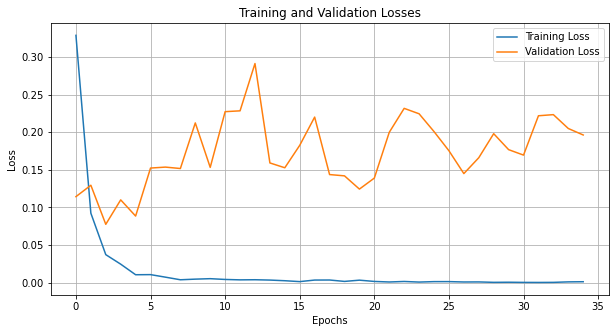

In [17]:
# Plotting the training and validation losses
print("Plotting the losses...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

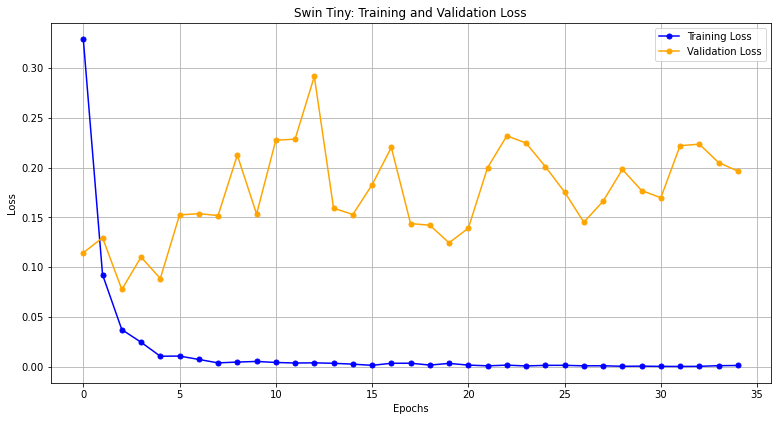

In [19]:
fig = plt.figure(figsize=(10,5)) # make plot
axis = fig.add_axes([0,0,1,1])
axis.plot(train_losses, color='blue', marker='o', ms=5)
axis.plot(val_losses, color='orange', marker='o', ms=5)
axis.set_ylabel("Loss")
axis.set_xlabel("Epochs")

axis.set_title("Swin Tiny: Training and Validation Loss")
axis.grid()

axis.legend(["Training Loss", "Validation Loss"])
plt.show()

In [20]:
# Function to evaluate the model on the validation or test set
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Evaluate the model on the validation set
y_true_val, y_pred_val = evaluate(model, val_loader, device)

In [23]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true_val, y_pred_val)
precision = precision_score(y_true_val, y_pred_val)
recall = recall_score(y_true_val, y_pred_val)
f1 = f1_score(y_true_val, y_pred_val)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Accuracy: 0.9802
Precision: 0.9964
Recall: 0.9596
F1 Score: 0.9777


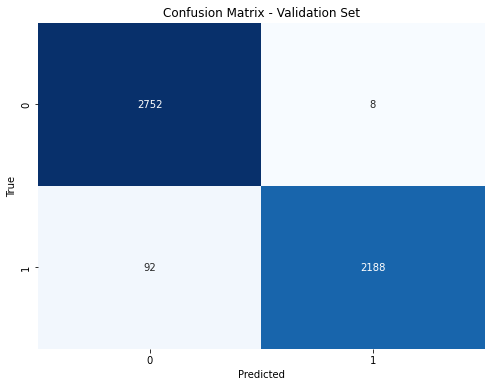

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

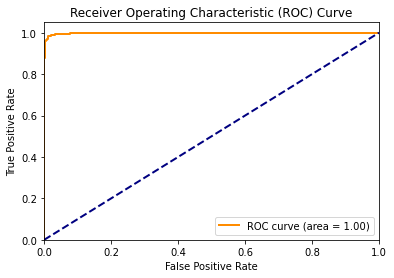

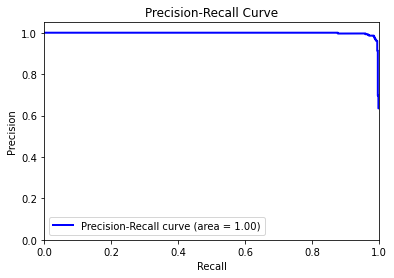

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC AUC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Function to get predicted probabilities
def predict_probabilities(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    return y_true, y_scores

# Get true labels and predicted probabilities
y_true_val, y_scores_val = predict_probabilities(model, val_loader, device)

# Extract probabilities for the positive class (assuming the positive class is class 1)
y_scores_positive = [score[1] for score in y_scores_val]

# Plot ROC AUC curve
plot_roc_curve(y_true_val, y_scores_positive)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_true_val, y_scores_positive)
